In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!git clone https://github.com/FloydMayweatherMachineLearningLab/runtime_prediction_assignment.git

fatal: destination path 'runtime_prediction_assignment' already exists and is not an empty directory.


## Imports

In [4]:
# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from typing import List
from scipy.stats import uniform

# Sytem & Files
import os
import sys
import inspect

# Machine learning
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, r2_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.base import clone


# NLP
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Constants

In [5]:
# If needed, change to your path in google drive
PATH_TO_FILES = "/content/runtime_prediction_assignment"
random_state = 0
test_size = 0.2
np.set_printoptions(precision=12)

## General Utils

In [6]:
def read_data(df_name: str):
    def remove_unnecessary_index(df: pd.DataFrame):
        """
        potentially remove redundant column created because
        the index value was not set to False when saving the dataframe.
        """
        # Check if the DataFrame has an 'Unnamed: 0' column (unnecessary index column)
        if 'Unnamed: 0' in df.columns:
            df.drop(columns=['Unnamed: 0'], inplace=True)
        return df

    df = pd.read_csv(os.path.join(PATH_TO_FILES, df_name))
    df = remove_unnecessary_index(df)
    return df


def one_hot_encode(df: pd.DataFrame, column_name: pd.DataFrame):
    "each column is seperated into 'numb of categories' columns binary representation"
    df_encoded = pd.get_dummies(df, columns=[column_name], prefix=[column_name])
    return df_encoded


def order_columns_by_first_df(first_df: pd.DataFrame, second_df: pd.DataFrame) -> pd.DataFrame:
    """
    Get the list of columns from the first DataFrame,
    then reorder the columns of the second DataFrame based on the order of columns in the first DataFrame
    """
    ordered_columns = first_df.columns.tolist()
    ordered_second_df = second_df[ordered_columns]
    return ordered_second_df


def display_wordcloud(text):
    "show the most common words in a text"
    large_text=" ".join(txt for txt in text)
    stop_words=stopwords.words('english')
    wordcloud = WordCloud(stopwords=stop_words,max_font_size=40, max_words=100, background_color="white").generate(large_text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


def convert_seconds_vectors_to_buckets(y_true, y_pred):
    bucket_label = [seconds2bucket(label) for label in y_true]
    bucket_pred = [seconds2bucket(pred) for pred in y_pred]
    return bucket_label, bucket_pred


## Convert seconds to bucket function, ~ do not edit ~
def seconds2bucket(s: float):
    if s < 1*60*60:
        return 0
    elif s < 2*60*60:
        return 1
    elif s < 4*60*60:
        return 2
    elif s < 8*60*60:
        return 3
    elif s < 12*60*60:
        return 4
    return 5


## Score function, ~ do not edit ~
def score(y_true: List[int], y_pred: List[int]):
    return f1_score(y_true, y_pred, average='weighted')

### Load data

In [7]:
df_train = read_data("train_data.csv")
df_test = read_data("test_data.csv")

# EDA

In [8]:
df_train.head(3)

,seconds,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,17482.052,f4142,1684225174927,d9df6,573f2,090a9,0,4,1,98f91,Dr Timothy Whittaker,da39a 516b9 5bab6 5a36f 14ddc 52b73 356a1 64e0...
1,64.141,24559,1684220255700,23908,6d0bd,090a9,1,2,1,98f91,Steven West-Williams,6d0bd 6f700 5fd0d bfb78 f5370 32035 58d1b 1f75...
2,1.301,4b920,1684220862466,dab03,42352,3ae78,1,8,1,98f91,Dr Peter Marsh,42352 c7eb6 c099a 63357 f7e66 fbd72 a2a8e dc72...


In [9]:
df_test.head(3)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,76dc2,1.684220e+12,98b1c,78fba,cbcf3,1,2,1,98f91,Denise Scott,4ffd2 902ba f1abd c7eb6 c18e2 63357 7b424 e274...
1,b8404,1.684220e+12,76c25,54275,5b376,1,2,1,98f91,Peter Morley,da39a c7eb6 c099a 9f5b2 a17c9 81cc4 bf938 626c...
2,f4142,1.684230e+12,111c7,573f2,090a9,1,4,1,98f91,Dr Kevin Blake,da39a 516b9 5bab6 5a36f 14ddc 52b73 356a1 64e0...


### Correlation between numerical features (including job runtime)

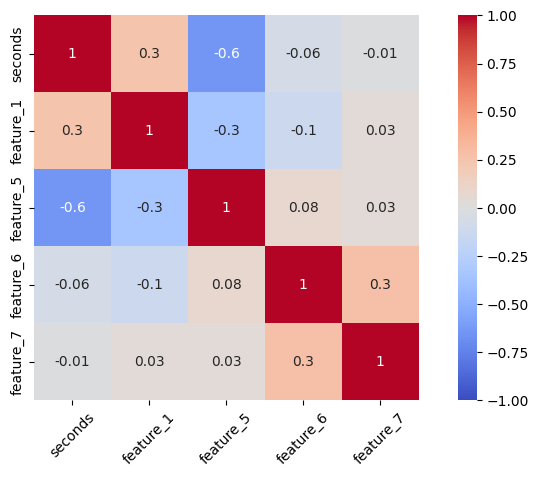

In [10]:
numerical_cols = list(df_train.select_dtypes(exclude='object').columns)
df_samp = df_train[numerical_cols]
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.heatmap(df_samp.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', square=True)
ax.tick_params(axis='x', labelrotation=45)

* from this heatmap we suspect that feature_5 is important for the price prediction, we'll keep that in mind when we get to feature selection phase...

### Correlation between categorical features to job runtime

In [11]:
df_train.select_dtypes(include=['object']).nunique()

feature_0        74
feature_2        58
feature_3       541
feature_4      8062
feature_8         3
feature_9       222
feature_10    33510
dtype: int64

<ipython-input-12-3b248a37616a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_df[col] = df_train[col]
<ipython-input-12-3b248a37616a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  box_df[col] = df_train[col]
<ipython-input-12-3b248a37616a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

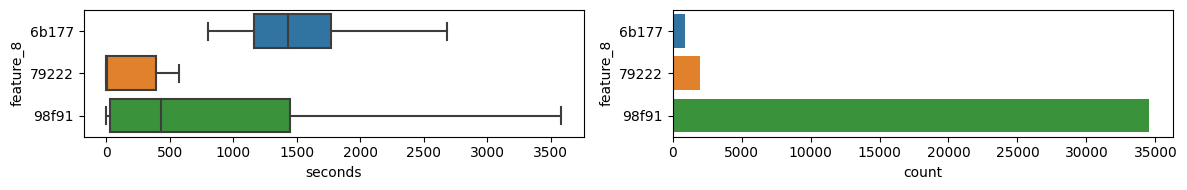

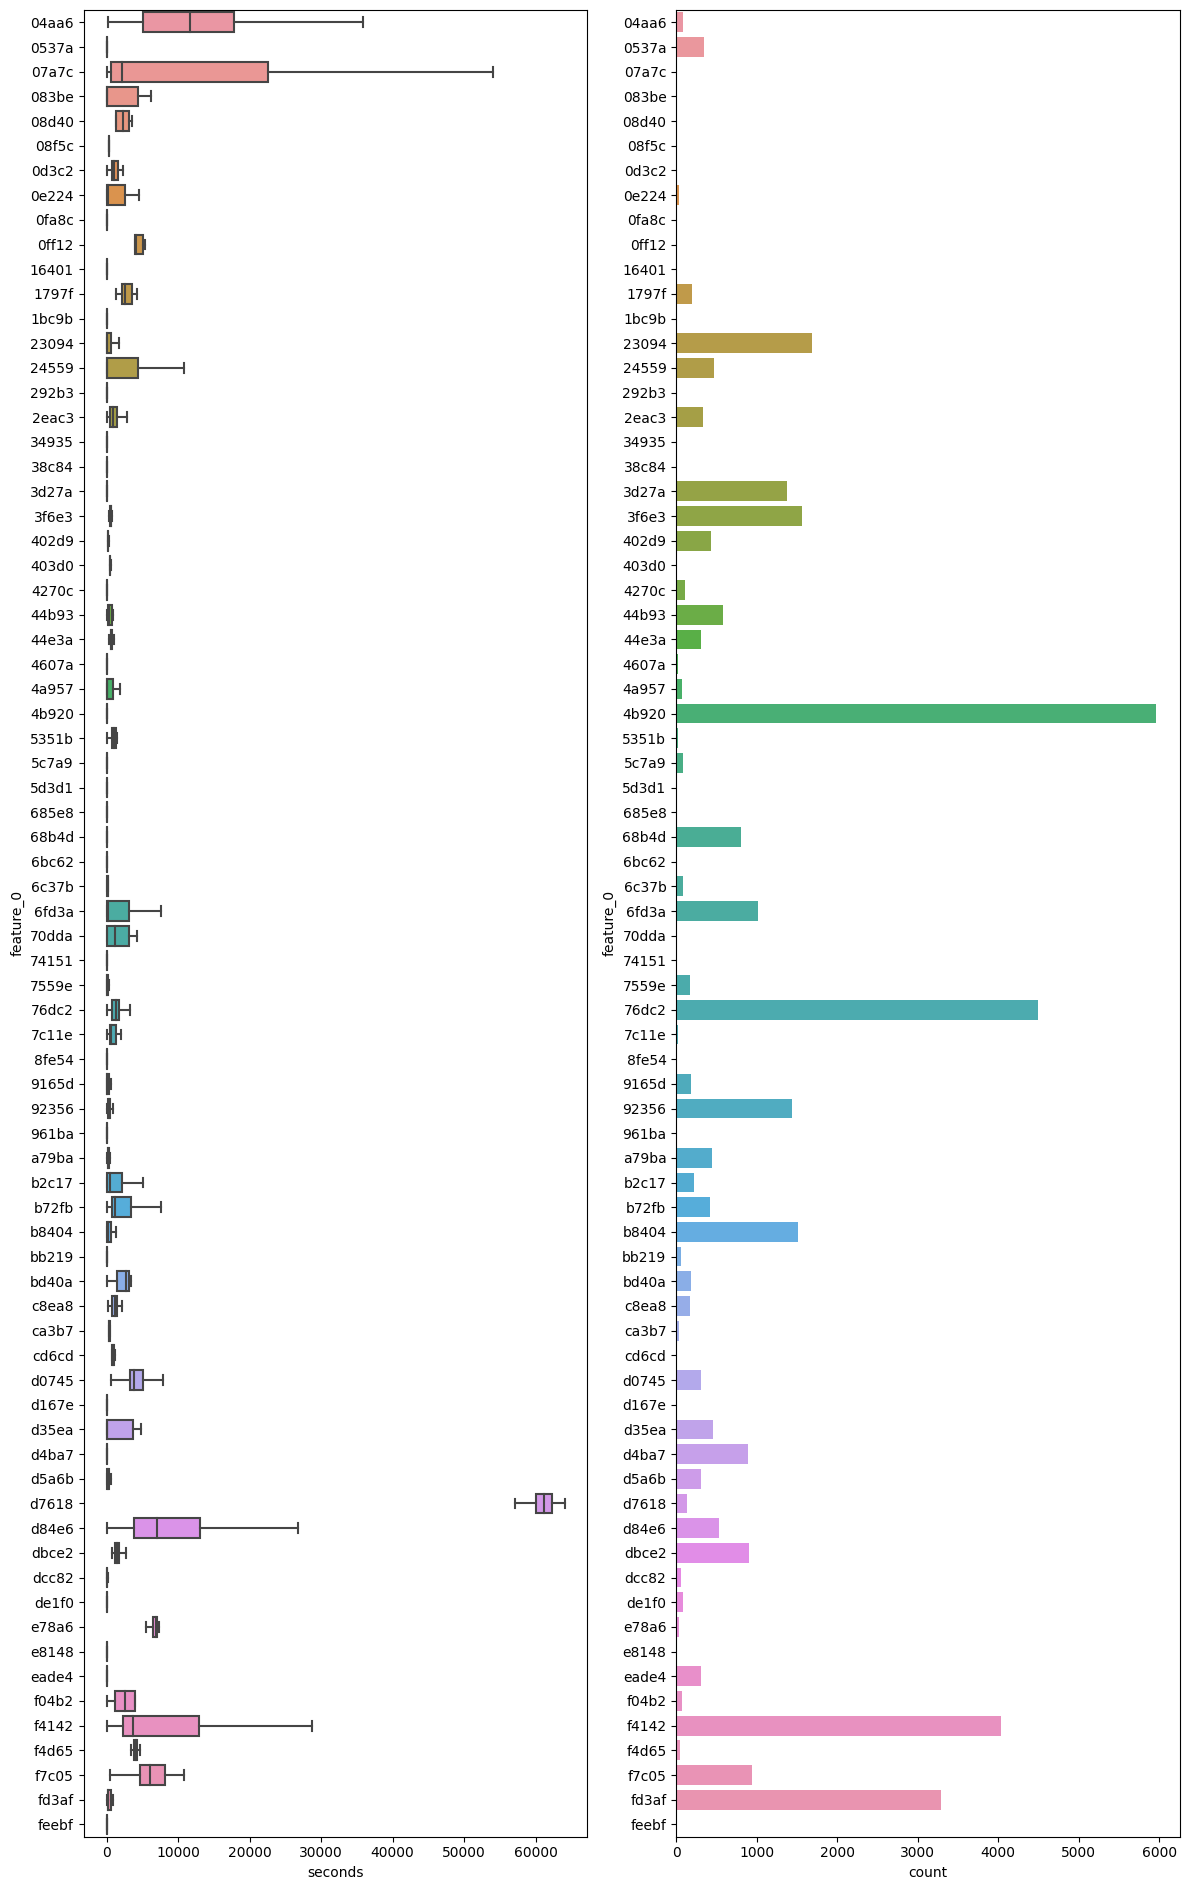

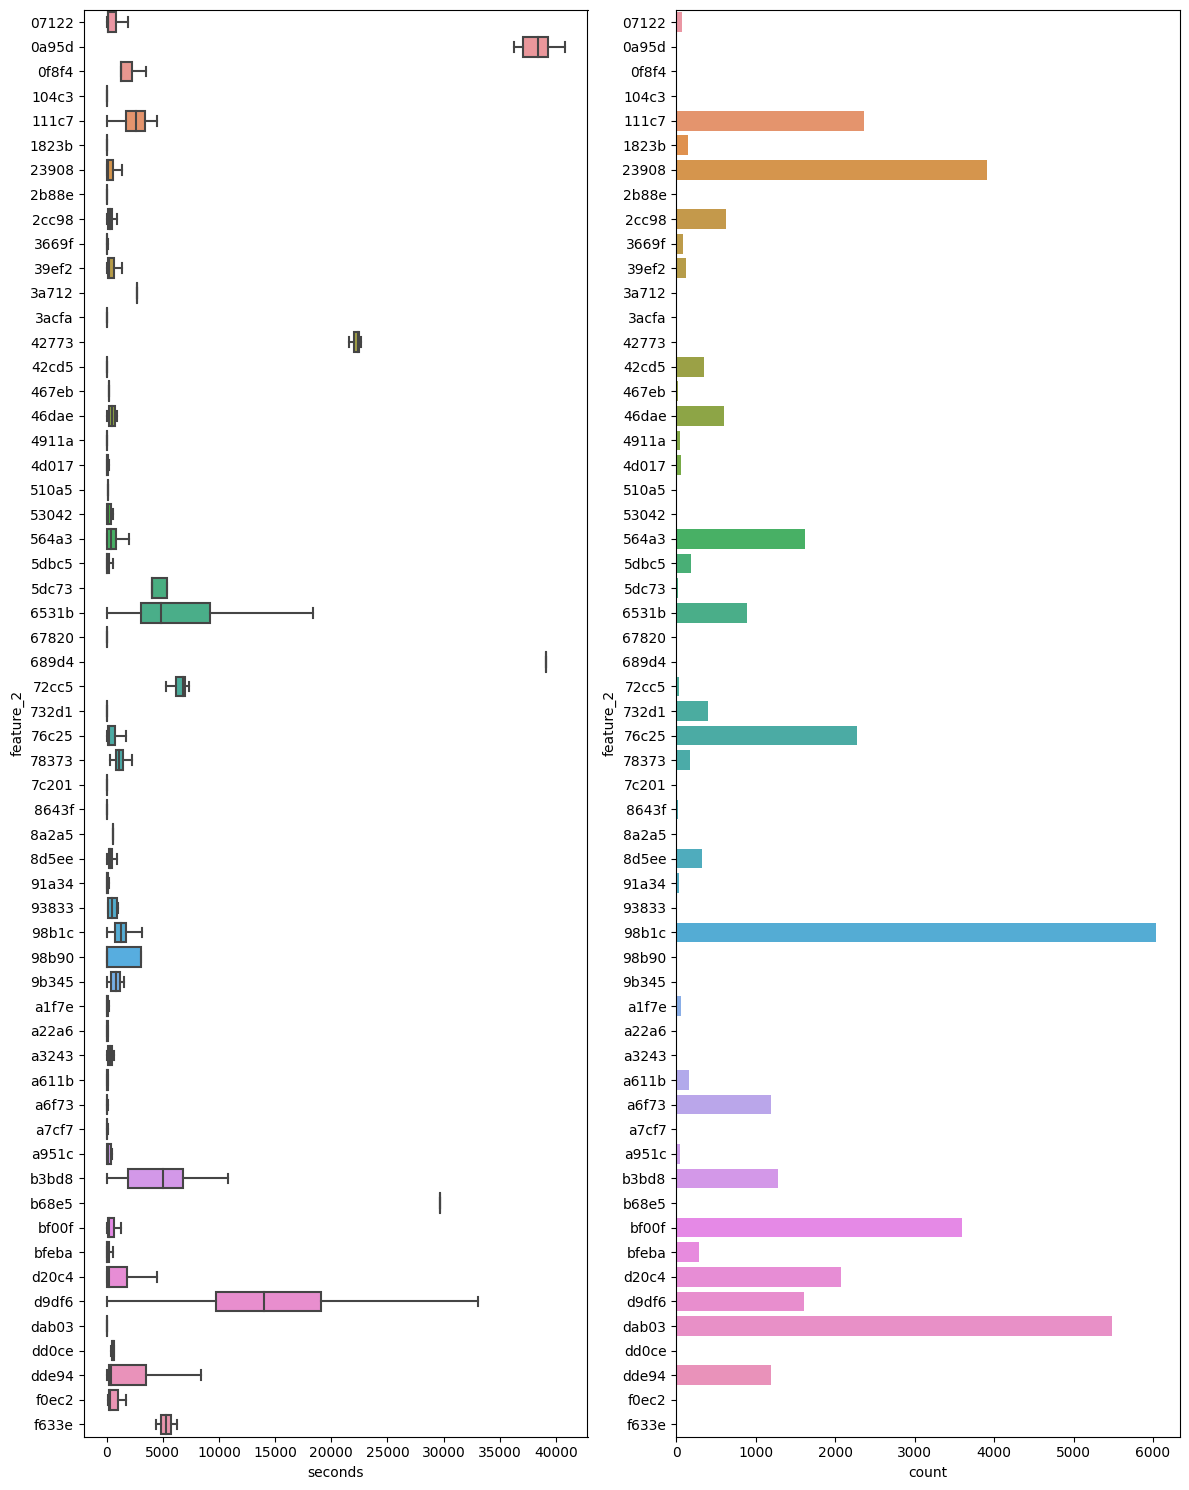

In [12]:
## Visualize for picked subset of categorical features, the rest are hard to display because of the large number of categories,
## we will review all the features correlations later on after encoding all columns.
box_cols = ['feature_8', 'feature_0', 'feature_2']
for col in box_cols:
    box_df = df_train[['seconds']]
    box_df[col] = df_train[col]
    box_order = pd.Series(df_train[col].unique()).sort_values()
    width = max(2, int(np.ceil(box_df[col].nunique()*0.25)))
    fig, ax = plt.subplots(1,2, figsize=(12, width))
    sns.boxplot(x='seconds', y=col, showfliers=False, data=box_df, order=box_order, ax=ax[0])
    sns.countplot(y=col, data=box_df, order=box_order, ax=ax[1])
    fig.tight_layout()

Out of curiosity, check what people names are responsible for the longest runtimes, and which are reponsible for the shorters runtimes

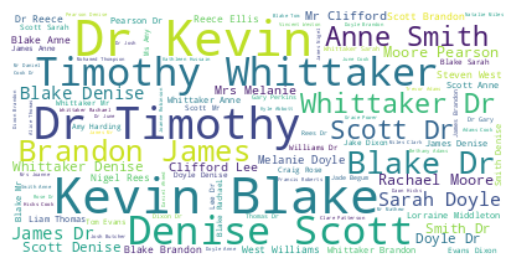

In [13]:
## Long runtime names
long_runtime_names = df_train[df_train.seconds > df_train.seconds.describe()['75%']].feature_9
display_wordcloud(long_runtime_names)

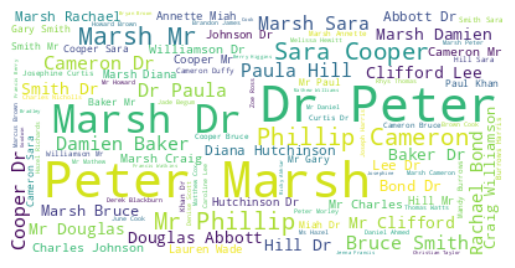

In [14]:
## Short runtime names
short_runtime_names = df_train[df_train.seconds < df_train.seconds.describe()['25%']].feature_9
display_wordcloud(short_runtime_names)

* we get a hint for importance of this feature, since we don't see the same common names in the slow and fast runtimes

### Check for runtime buckets class imbalance

In [15]:
df_train.seconds.apply(lambda s: seconds2bucket(s)).value_counts()

0    32740
1     2169
2     1315
3      863
5      244
4      169
Name: seconds, dtype: int64

* 0 bucket (job runtime of under an hour) is significantly larger than the other classes, basically all of the other classes are misrepresented
* given that we don't have enough domain knowledge on this problem, and what kind of buckets ratio is expected in reality, the potential approach will be to perform minority oversampling but not drastically
* we will perform oversampling in the Optimization phase

## Imputation & Cleanup

### Check for null values in train and test sets

In [16]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum() # no null values

(0, 0)

### dtypes transformations

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   seconds     37500 non-null  float64
 1   feature_0   37500 non-null  object 
 2   feature_1   37500 non-null  int64  
 3   feature_2   37500 non-null  object 
 4   feature_3   37500 non-null  object 
 5   feature_4   37500 non-null  object 
 6   feature_5   37500 non-null  int64  
 7   feature_6   37500 non-null  int64  
 8   feature_7   37500 non-null  int64  
 9   feature_8   37500 non-null  object 
 10  feature_9   37500 non-null  object 
 11  feature_10  37500 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 3.4+ MB


In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12500 entries, 0 to 12499
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_0   12500 non-null  object 
 1   feature_1   12500 non-null  float64
 2   feature_2   12500 non-null  object 
 3   feature_3   12500 non-null  object 
 4   feature_4   12500 non-null  object 
 5   feature_5   12500 non-null  int64  
 6   feature_6   12500 non-null  int64  
 7   feature_7   12500 non-null  int64  
 8   feature_8   12500 non-null  object 
 9   feature_9   12500 non-null  object 
 10  feature_10  12500 non-null  object 
dtypes: float64(1), int64(3), object(7)
memory usage: 1.0+ MB


In [19]:
df_train.dtypes[1:] == df_test.dtypes

feature_0      True
feature_1     False
feature_2      True
feature_3      True
feature_4      True
feature_5      True
feature_6      True
feature_7      True
feature_8      True
feature_9      True
feature_10     True
dtype: bool

*  feature_1 is the only incosistent data type, let's check it out

In [20]:
df_train.feature_1.unique()

array([1684225174927, 1684220255700, 1684220862466, ..., 1684222925589,
       1684220349933, 1684225634969])

In [21]:
list(df_test.feature_1.unique()) # integers with .0 at the end -> unnecessary -> convert to int64 to save memory and keep data consistency

[1684220000000.0, 1684230000000.0]

In [22]:
df_test.feature_1 = df_test.feature_1.astype('int64')

 transform 'object' dtype feature columns into the appropriate type to ease up on memory and time consumption

In [23]:
df_train.select_dtypes(include=['object']).nunique() # features of type 'object' have unique, repetetive values - hint for categorical variable

feature_0        74
feature_2        58
feature_3       541
feature_4      8062
feature_8         3
feature_9       222
feature_10    33510
dtype: int64

In [24]:
## object to category transformation
obj_df = df_train.select_dtypes(include=['object'])
for column_name in list(obj_df.columns):
    df_train[column_name] = df_train[column_name].astype('category')
    df_test[column_name] = df_test[column_name].astype('category')

In [25]:
df_train.dtypes

seconds        float64
feature_0     category
feature_1        int64
feature_2     category
feature_3     category
feature_4     category
feature_5        int64
feature_6        int64
feature_7        int64
feature_8     category
feature_9     category
feature_10    category
dtype: object

## Category encoding
choose the encoding method according to the number of unqiue categories in a column

In [26]:
categorical_columns = list(set(df_train.columns) - set(numerical_cols))

for column in categorical_columns:
    print(f'column: {column}, number of unique categories: {df_train[[column]].nunique().iloc[0]}')

column: feature_0, number of unique categories: 74
column: feature_3, number of unique categories: 541
column: feature_2, number of unique categories: 58
column: feature_10, number of unique categories: 33510
column: feature_8, number of unique categories: 3
column: feature_9, number of unique categories: 222
column: feature_4, number of unique categories: 8062


* feature_4 and feature_10 raise suspicions... especially feature_10 since it contains a very large number of unique categories

In [27]:
df_train.feature_10.sample(1).iloc[0]

'da39a c7eb6 c099a 63357 f7e66 83e80 e274e da4c0 71b3f e2692 97275 04d13 f1e7b 1243b 8b39d d9ebc'

In [28]:
try:
    int(df_train.feature_10.sample(1).iloc[0])
except Exception:
    print("can not convert feature_10 entry string into an integer")

can not convert feature_10 entry string into an integer


* wierd, looks like a column that contains hash values that are not learnable, will be taken into consideration later

In [29]:
## create copies of the dataframes for potential retrieval of original values
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()

## encode the different features differently according to the numb of unique categories in them,
one_hot_encode_numbs = [2, 8, 0, 9]
dfs = [df_train_encoded, df_test_encoded]

Perform one hot encoding:

In [30]:
for i, df in enumerate(dfs):
    for numb in one_hot_encode_numbs:
        df = one_hot_encode(df, f'feature_{str(numb)}')
    dfs[i] = df

df_train_encoded, df_test_encoded = dfs
df_train_encoded.head(3)

,seconds,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_2_07122,feature_2_0a95d,...,feature_9_Tom Dunn,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams,feature_9_Valerie Lynch-Armstrong,feature_9_Victor Cross,feature_9_Victor Reed,feature_9_Vincent Walton,feature_9_Vincent Weston,feature_9_William Rhodes,feature_9_Zoe Ross
0,17482.052,1684225174927,573f2,090a9,0,4,1,da39a 516b9 5bab6 5a36f 14ddc 52b73 356a1 64e0...,0,0,...,0,0,0,0,0,0,0,0,0,0
1,64.141,1684220255700,6d0bd,090a9,1,2,1,6d0bd 6f700 5fd0d bfb78 f5370 32035 58d1b 1f75...,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.301,1684220862466,42352,3ae78,1,8,1,42352 c7eb6 c099a 63357 f7e66 fbd72 a2a8e dc72...,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
df_train_encoded.shape, df_test_encoded.shape

((37500, 365), (12500, 298))

* as we can see, the number of resulted columns in the train and test sets are different by more than one, meaning that there are categories that exist in the train set and don't exist in the test set.

* in addition, there might be categories that exist in the test set that don't exist in the train set.
we have to deal with both these problems:

In [32]:
def handle_unseen_categories(train_set, test_set):
    """
    this function aims to solve two problems:
    1) categories that exist in the train set but not in the test set,
    should artificially be filled in with a zero vector of test set length
    2) categories that exist in the test set, but not in the train set,
    cause extra columns in the test set, which will be dropped

    """
    train_set_columns = set(train_set.columns)
    print('Drop extra one hot encoded columns in the test data that are not present in the training data')
    extra_columns_in_test = set(test_set.columns) - train_set_columns
    print(f'the extra columns in the test set are: {list(extra_columns_in_test)}\nextra columns in test set consist of {len(extra_columns_in_test) / (len(test_set.columns))} of all the columns')
    print(f'dropping {len(extra_columns_in_test)} test set encoded columns...')
    print()
    test_set = test_set.drop(columns=extra_columns_in_test)
    # Add missing columns with all-zero values in the test data
    print('setting columns that exist in the train set but not the test set with zeros to keep shape consistency....')
    for col in train_set_columns:
        if col not in test_set.columns and col!='seconds':
            print(f'setting column {col} with zeros')
            test_set[col] = 0
    return test_set

df_test_encoded = handle_unseen_categories(df_train_encoded, df_test_encoded)

Drop extra one hot encoded columns in the test data that are not present in the training data
the extra columns in the test set are: ['feature_0_e937b', 'feature_9_Dr Anthony Parker', 'feature_0_253da', 'feature_0_6.85E+10', 'feature_9_Rachael Hill', 'feature_0_0.00E+00', 'feature_9_Simon Perkins', 'feature_9_Kathryn Carter', 'feature_9_Gordon Rose', 'feature_2_7122', 'feature_9_Howard Newton', 'feature_9_Jeremy Donnelly-Thomson', 'feature_9_Lorraine Harvey', "feature_9_Mr Liam O'Connor"]
extra columns in test set consist of 0.04697986577181208 of all the columns
dropping 14 test set encoded columns...

setting columns that exist in the train set but not the test set with zeros to keep shape consistency....
setting column feature_9_Dr Antony Cooke with zeros
setting column feature_9_Dr Brian Rahman with zeros
setting column feature_0_685e8 with zeros
setting column feature_9_Kieran O'Connor with zeros
setting column feature_9_Joanna Williams with zeros
setting column feature_2_b68e5 wi

In [33]:
df_train_encoded.shape, df_test_encoded.shape

((37500, 365), (12500, 364))

In [34]:
set(df_train_encoded.columns) - set(df_test_encoded.columns) # same feature columns in train and test sets

{'seconds'}

now we move on to columns with a large number of unique categories, to which we will perform label encoding (integer encoding):

In [35]:
class CustomLabelEncoder:
    """
    this class maps each unique category in a
    column to a unique integer, in addition, it handles
    unseen categories - the test data could contain
    categories unseen in the train set, such categories will
    be filled -1 as a common practice for these cases.
    """
    def __init__(self):
        self.label_mapping = {}
        self.transformed_labels = []

    def fit_transform(self, labels):
        self.fit(labels)
        return self.transform(labels)

    def fit(self, labels):
        self.label_mapping = {label: i for i, label in enumerate(set(labels))}

    def transform(self, labels):
        return [self.label_mapping[label] if label in self.label_mapping else -1 for label in labels]

In [36]:
label_encode_numbs = [4, 3, 10]
for numb in label_encode_numbs:
    column_name = f'feature_{str(numb)}'
    label_encoder = CustomLabelEncoder()
    df_train_encoded[column_name] = label_encoder.fit_transform(df_train_encoded[column_name])
    df_test_encoded[column_name] = label_encoder.transform(df_test_encoded[column_name]) # transform test set featrues with train set labeler -> to get common categories.

In [37]:
df_train_encoded.info() # we are left with numeric columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37500 entries, 0 to 37499
Columns: 365 entries, seconds to feature_9_Zoe Ross
dtypes: float64(1), int64(7), uint8(357)
memory usage: 15.1 MB


## Look for outliers

In [38]:
df_train.select_dtypes(include=['int64']).head()

,feature_1,feature_5,feature_6,feature_7
0,1684225174927,0,4,1
1,1684220255700,1,2,1
2,1684220862466,1,8,1
3,1684222604220,0,2,1
4,1684223766232,1,2,1


In [39]:
df_train_encoded.feature_7.unique(), df_train_encoded.feature_5.unique(), df_train_encoded.feature_6.unique()

(array([ 1,  2,  6,  4,  8, 16, 12,  3]),
 array([0, 1]),
 array([  4,   2,   8,  16,  24,   1,  32, 250,   9,  64,  19,  36,  30,
        128,  14,  80,  22,   3, 110, 100,  96, 256,   5,  10, 127,  35,
         15, 200,  25, 273, 196,  86,  63,  60, 120,  12]))

* Features 5, 6, 7 are low-cardinality numerical vectors, hence the concept of outliers doesn't make sense for them, we will look for outliers in features that are high cardinality numerical vectors --> meaning feature_1 only.

<Axes: ylabel='feature_1'>

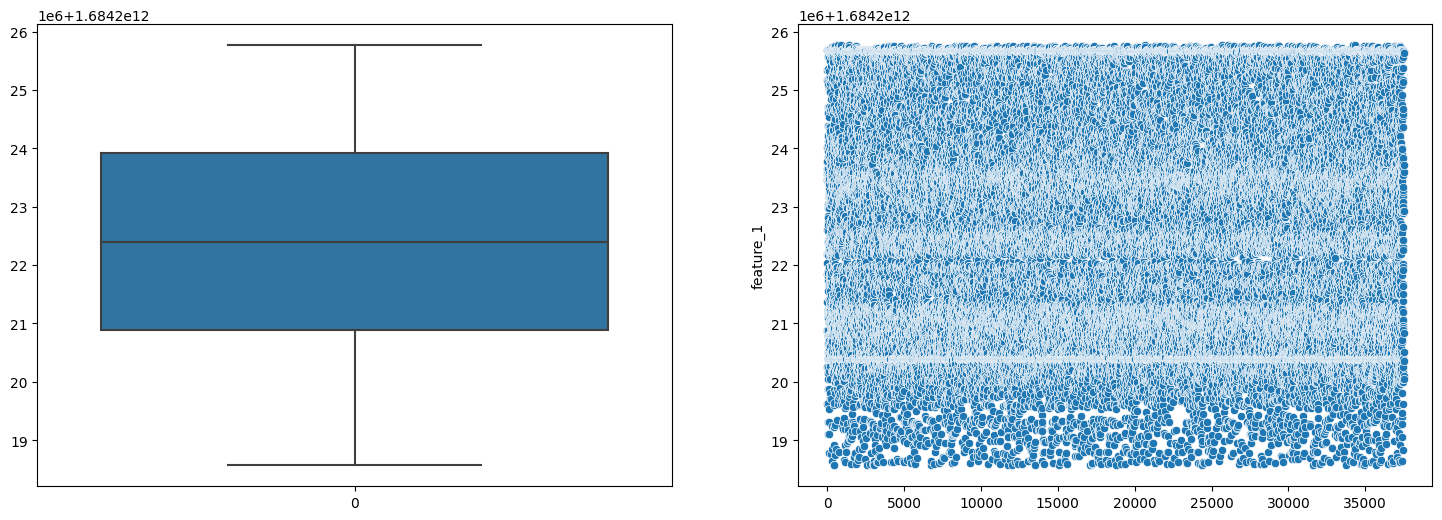

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(18,6))
sns.boxplot(df_train_encoded.feature_1, showfliers=False,  ax=axs[0])
sns.scatterplot(df_train_encoded.feature_1, ax=axs[1])

* no outliers, looks like a uniform distribution

In [41]:
scaler = StandardScaler()
scaled_feature_1 = scaler.fit_transform(df_train_encoded[['feature_1']])
scaled_feature_1 = pd.Series(scaled_feature_1.ravel())
scaled_feature_1.head()

0    1.428937
1   -1.195086
2   -0.871423
3    0.057666
4    0.677509
dtype: float64

In [43]:
z_score_threshold = 2.5 #  approximately 98.3% of the data falls within 2.5 standard deviations from the mean.
outliers = scaled_feature_1[abs(scaled_feature_1) > z_score_threshold]
outliers

Series([], dtype: float64)

# Modeling

### Modeling Utils

In [44]:
def plot_confusion_matrix(y_true, y_pred, normalize=True, cmap='Blues', problem_type='regression'):
    """
    Plot the confusion matrix between y_true and y_pred.

    Args:
        normalize: bool, optional: Whether to normalize the confusion matrix or not. Default is True.
        cmap: str, optional: Colormap for the heatmap. Default is 'Blues'.
    """
    classes = [i for i in range(6)]

    if problem_type == 'regression':
        y_true, y_pred = convert_seconds_vectors_to_buckets(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, ax=ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.show()
    return cm


def calc_classification_metrics_per_class(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score_ = np.zeros(num_classes)
    for i in range(num_classes):
        true_positives = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positives
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positives
        precision[i] = true_positives / (true_positives + false_positives)
        recall[i] = true_positives / (true_positives + false_negatives)
        f1_score_[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

    return precision, recall, f1_score_


def split_into_train_and_validation(df: pd.DataFrame, test_size: float = test_size, random_state = random_state, target_column = 'seconds'):
    X = df.iloc[:, 1:]
    y = df.loc[:, target_column]
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_val, y_train, y_val


def k_fold_binning(df: pd.DataFrame, k = 5, target_column = 'seconds'):
    """
    return k different versions of train and validation sets.
    """
    num_samples = len(df)
    fold_size = num_samples // k
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    X = df.iloc[:, 1:]
    y = df.loc[:, target_column]

    X_train_list, X_val_list, y_train_list, y_val_list = [], [], [], []

    for i in range(k):
        start_idx = i * fold_size
        end_idx = start_idx + fold_size

        val_indices = indices[start_idx:end_idx]
        train_indices = np.concatenate((indices[:start_idx], indices[end_idx:]))

        X_train, X_val = X.iloc[train_indices], X.iloc[val_indices]
        y_train, y_val = y.iloc[train_indices], y.iloc[val_indices]

        X_train_list.append(X_train)
        X_val_list.append(X_val)
        y_train_list.append(y_train)
        y_val_list.append(y_val)

    return X_train_list, X_val_list, y_train_list, y_val_list


def calc_r_squared(y_true, y_pred):
    r_squared = r2_score(y_true, y_pred)
    return r_squared


def calc_msle(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    # Ensure non-negative values for MSLE calculation
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    msle = np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2)
    return msle


def calc_f1_score(y_true, y_pred, problem_type='regression'):
    if problem_type == 'regression':
        bucket_label, bucket_pred = convert_seconds_vectors_to_buckets(y_true, y_pred)
    else:
        bucket_label, bucket_pred = y_true, y_pred
    f1_score = score(bucket_label, bucket_pred)
    return f1_score


def display_model_performance_results(model, df, k=5, problem_type='regression'):
    target_column = 'seconds' if problem_type == 'regression' else 'runtime_buckets'
    X_train_list, X_val_list, y_train_list, y_val_list = k_fold_binning(df, k=k, target_column=target_column)
    validation_f1_scores = []
    if problem_type == 'regression':
        r_squared_scores = []
        msle_scores = []

    for i, X_train in enumerate(X_train_list):
        X_val = X_val_list[i]
        y_train = y_train_list[i]
        y_val = y_val_list[i]
        if i > 0:
            model = clone(model) # Construct a new unfitted estimator with the same parameters
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        f1_score = calc_f1_score(y_val, y_pred, problem_type=problem_type)
        validation_f1_scores.append(f1_score)
        if problem_type == 'regression':
            msle = calc_msle(y_val, y_pred)
            msle_scores.append(msle)
            r_squared = calc_r_squared(y_val, y_pred)
            r_squared_scores.append(r_squared)

    print(f"Validation sets Scores summary on all folds:")
    print(f"Average f1 score on {k} fold cross validation: {np.mean(validation_f1_scores)}")
    if problem_type == 'regression':
        print(f"Average mean squared Logarithmic error score on {k} fold cross validation: {np.mean(msle_scores)}")
        print(f"Average R squared score on {k} fold cross validation: {np.mean(r_squared_scores)}")


def visualize_goodness_of_fit(y_true, y_pred):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_true, y=y_pred, color='blue', label = 'Predicted vs True (Hours)')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Goodness of Fit - Predicted vs. True Hours')
    plt.legend()
    plt.grid(True)
    plt.show()

### Baseline solution, provided by the core notebook framework

In [45]:
# Example for a solution - a naive linear regression model followed by bucket classification
numeric_features = ["feature_1", "feature_5", "feature_6", "feature_7"]
X = df_train[numeric_features]
y = df_train['seconds']
df_numeric = pd.concat([y, X], axis=1)
model = LinearRegression()
display_model_performance_results(model, df_numeric)

Validation sets Scores summary on all folds:
Average f1 score on 5 fold cross validation: 0.8882531128486507
Average mean squared Logarithmic error score on 5 fold cross validation: 7.438003549967395
Average R squared score on 5 fold cross validation: 0.4142177579410742


### Baseline 2, after taking into consideration categorical variables

In [46]:
model = LinearRegression()
display_model_performance_results(model, df_train_encoded)

Validation sets Scores summary on all folds:
Average f1 score on 5 fold cross validation: 0.9399422278327677
Average mean squared Logarithmic error score on 5 fold cross validation: 2.7383970196082394
Average R squared score on 5 fold cross validation: 0.7889618805376294


Previously we stated that feature_10 is suspected to not add any value to the model prediction, because it consists of a very large number of unique categories, let's check this hypothesis:

In [47]:
model = LinearRegression()
display_model_performance_results(model, df_train_encoded.drop('feature_10', axis=1))

Validation sets Scores summary on all folds:
Average f1 score on 5 fold cross validation: 0.9399712479120265
Average mean squared Logarithmic error score on 5 fold cross validation: 2.7355130598047226
Average R squared score on 5 fold cross validation: 0.7893891384278262


* the result suggests that this column is not be providing significant additional information to the model, however at this point we won't drop it, we will let feature selection algorithm later on take that decision based on statiscal analysis of feature-target correlation

# Start Pipeline

## Normalize all features

In [50]:
def min_max_scaling(df, scaler=None):
    "scale both train and test sets based on the train data learned parameters"
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(df)
    else:
        scaled_data = scaler.transform(df)
    scaled_df = pd.DataFrame(scaled_data, columns=df.columns)
    return [scaler, scaled_df]

In [51]:
 # ensure train and test sets features are ordered similarly
df_test_encoded = order_columns_by_first_df(df_train_encoded.drop('seconds', axis=1), df_test_encoded)

In [55]:
X_train = df_train_encoded.drop('seconds', axis=1)
y_train = df_train_encoded.seconds

In [56]:
train_set_scaler, X_train_scaled = min_max_scaling(X_train)
df_train_encoded_scaled = pd.concat([y_train, X_train_scaled], axis=1)
_, df_test_encoded_scaled = min_max_scaling(df_test_encoded, train_set_scaler)

In [57]:
df_train_encoded_scaled.describe()

,seconds,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_2_07122,feature_2_0a95d,...,feature_9_Tom Dunn,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams,feature_9_Valerie Lynch-Armstrong,feature_9_Victor Cross,feature_9_Victor Reed,feature_9_Vincent Walton,feature_9_Vincent Weston,feature_9_William Rhodes,feature_9_Zoe Ross
count,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,...,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000,37500.000000
mean,2192.293933,0.545627,0.535255,0.461310,0.873067,0.034069,0.008866,0.497395,0.001947,0.000187,...,0.000187,0.002560,0.001227,0.000053,0.000027,0.002373,0.000027,0.000907,0.000053,0.002160
std,6406.286202,0.260450,0.249650,0.247209,0.332903,0.067297,0.056803,0.285460,0.044079,0.013662,...,0.013662,0.050532,0.035003,0.007303,0.005164,0.048660,0.005164,0.030098,0.007303,0.046426
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.929500,0.322311,0.305556,0.244883,1.000000,0.003676,0.000000,0.259565,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,424.092500,0.530845,0.612963,0.456643,1.000000,0.011029,0.000000,0.487406,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1484.339000,0.743069,0.646296,0.598313,1.000000,0.055147,0.000000,0.742375,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,85053.607000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
df_test_encoded_scaled.describe()

,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_2_07122,feature_2_0a95d,feature_2_0f8f4,...,feature_9_Tom Dunn,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams,feature_9_Valerie Lynch-Armstrong,feature_9_Victor Cross,feature_9_Victor Reed,feature_9_Vincent Walton,feature_9_Vincent Weston,feature_9_William Rhodes,feature_9_Zoe Ross
count,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.0,12500.000000,12500.000000,...,12500.000000,12500.000000,12500.00000,12500.000000,12500.0,12500.00000,12500.0,12500.00000,12500.000000,12500.00000
mean,0.394458,0.528580,0.341510,0.871280,0.033794,0.008773,0.059256,0.0,0.000320,0.000080,...,0.000240,0.003040,0.00160,0.000080,0.0,0.00248,0.0,0.00160,0.000080,0.00248
std,0.483231,0.254309,0.285030,0.334903,0.066947,0.053888,0.181751,0.0,0.017886,0.008944,...,0.015491,0.055055,0.03997,0.008944,0.0,0.04974,0.0,0.03997,0.008944,0.04974
min,0.198848,-0.001852,-0.000124,0.000000,0.000000,0.000000,-0.000030,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.00000
25%,0.198848,0.305556,0.009428,1.000000,0.003676,0.000000,-0.000030,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.00000
50%,0.198848,0.612963,0.314353,1.000000,0.011029,0.000000,-0.000030,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.00000
75%,0.198848,0.646296,0.575611,1.000000,0.055147,0.000000,-0.000030,0.0,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.0,0.00000,0.0,0.00000,0.000000,0.00000
max,1.588124,0.998148,0.993797,1.000000,1.000000,1.000000,0.998478,0.0,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,0.0,1.00000,0.0,1.00000,1.000000,1.00000


In [59]:
df_train_encoded_scaled.head()

,seconds,feature_1,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_2_07122,feature_2_0a95d,...,feature_9_Tom Dunn,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams,feature_9_Valerie Lynch-Armstrong,feature_9_Victor Cross,feature_9_Victor Reed,feature_9_Vincent Walton,feature_9_Vincent Weston,feature_9_William Rhodes,feature_9_Zoe Ross
0,17482.052,0.917788,0.638889,0.456643,0.0,0.011029,0.0,0.691725,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64.141,0.234372,0.627778,0.456643,1.0,0.003676,0.0,0.983139,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.301,0.318668,0.305556,0.377993,1.0,0.025735,0.0,0.264228,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3907.559,0.560646,0.570370,0.581193,0.0,0.003676,0.0,0.844310,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35.489,0.722082,0.309259,0.458752,1.0,0.003676,0.0,0.357874,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Define the pipeline

In [61]:
class MetaModel():
    def __init__(self, model_name, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.search_params_dict = None
        self.best_params = None
        self.model_name = model_name
        if 'neighbours' in model_name:
            self.search_params_dict = {
                'n_neighbors': [3, 5, 7, 9],
                'weights': ['uniform', 'distance'],
            }
        elif 'forest' in model_name:
            self.search_params_dict = {
                "max_depth":[3,5,7,10],
                "min_samples_split":[8,12,16,24,30],
                "min_samples_leaf":[50,100,150,200],
                "n_estimators":[100,250,500,750,1000,1500,2000],
                "max_features": ['auto', 'sqrt',0.2]
            }
        elif 'xgb' in model_name:
            self.search_params_dict = {
                "learning_rate": uniform(loc=0.001, scale=0.1),
                "max_depth": [3, 4, 5, 6, 8, 10, 12, 15],
                "min_child_weight": [1, 3, 5, 7],
                "gamma": uniform(loc=0, scale=0.5),
                "colsample_bytree": np.linspace(0.2, 0.7, 5)
            }

    def initialize_model(self, hyper_parameters=None):
        if 'xgb' in self.model_name:
            if hyper_parameters is None:
                model = XGBRegressor()
            else:
                model = XGBRegressor(**hyper_parameters)
        elif 'neighbours' in self.model_name:
            if hyper_parameters is None:
                model = KNeighborsRegressor()
            else:
                model = KNeighborsRegressor(**hyper_parameters)
        elif 'forest' in self.model_name:
            if hyper_parameters is None:
                model = RandomForestRegressor()
            else:
                model = RandomForestRegressor(**hyper_parameters)
        self.model = model

    def fit_transform(self, n_search_iterations=3, k=5):
        best_model_summary = None
        min_error = float('inf') # will help us keep track of the best model
        # Hyperparameter search using randomized search
        for _ in range(n_search_iterations):
            self.randomized_search_cv(self.X_train, self.y_train)
            # Perform k-fold cross-validation
            X_train_list, X_val_list, y_train_list, y_val_list = k_fold_binning(df=pd.concat([self.y_train, self.X_train], axis=1), k=k)
            msle_list = []
            f1_score_list = []
            r_squared_list = []
            for i in range(len(X_train_list)):
                X_train_fold = X_train_list[i]
                X_val_fold = X_val_list[i]
                y_train_fold = y_train_list[i]
                y_val_fold = y_val_list[i]
                # Fit model with best hyper parameters on data fold
                self.initialize_model(hyper_parameters=self.best_params)
                self.model.fit(X_train_fold, y_train_fold)
                # Evaluate model performance using MSLE
                y_pred_val_fold = self.model.predict(X_val_fold)
                msle = calc_msle(y_val_fold, y_pred_val_fold)
                # Store other metrics scores for tracking purposes
                f1_val_score = calc_f1_score(y_val_fold, y_pred_val_fold)
                r_squared = calc_r_squared(y_val_fold, y_pred_val_fold)
                msle_list.append(msle)
                f1_score_list.append(f1_val_score)
                r_squared_list.append(r_squared)

            msle_avg = np.mean(msle_list)
            f1_score_avg = np.mean(f1_score_list)
            r_squared_avg = np.mean(r_squared_list)
            # Track the best model
            if msle_avg < min_error:
                min_error = msle_avg
                best_model_summary = {
                        'hyperparameters': self.best_params,
                        'msle': msle_avg,
                        'f1_score': f1_score_avg,
                        'r_squared': r_squared_avg
                }

                print('current best model attributes:')
                print(best_model_summary)



        return best_model_summary

    def randomized_search_cv(self, X_train, y_train):
        self.initialize_model()
        random_search = RandomizedSearchCV(self.model, param_distributions=self.search_params_dict , n_iter=5, cv=3)
        random_search.fit(X_train, y_train)
        self.best_params = random_search.best_params_



def perform_pipeline(X_train, y_train):
    model_names = ['k nearest neighbours regressor', 'random forest', 'xgboost']
    results = {k:None for k in model_names}
    for model_name in model_names:
        print(f'applying full pipeline on {model_name} model')
        start_time = time.time()
        meta_model = MetaModel(model_name, X_train, y_train)
        best_model = meta_model.fit_transform()
        results[model_name] = best_model
        end_time = time.time()
        print(f"Done! took {(end_time - start_time) / 3600} hours to find the best model...")
    return results

In [67]:
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

res = perform_pipeline(df_train_encoded_scaled.drop('seconds', axis=1), df_train_encoded_scaled.seconds)

warnings.filterwarnings("default", category=RuntimeWarning)
warnings.filterwarnings('default', category=UserWarning)
warnings.filterwarnings('default', category=FutureWarning)

res

applying full pipeline on k nearest neighbours regressor model
current best model attributes:
{'hyperparameters': {'weights': 'distance', 'n_neighbors': 9}, 'msle': 0.547361171069688, 'f1_score': 0.9599057923271964, 'r_squared': 0.8297792565802311}
current best model attributes:
{'hyperparameters': {'weights': 'distance', 'n_neighbors': 9}, 'msle': 0.5465736095918151, 'f1_score': 0.9594805545296149, 'r_squared': 0.8272822720542766}
current best model attributes:
{'hyperparameters': {'weights': 'distance', 'n_neighbors': 7}, 'msle': 0.5395977063557595, 'f1_score': 0.9609703221191263, 'r_squared': 0.8258147132078036}
Done! took 0.10001134084330665 hours to find the best model...
applying full pipeline on random forest model
current best model attributes:
{'hyperparameters': {'n_estimators': 1500, 'min_samples_split': 8, 'min_samples_leaf': 150, 'max_features': 0.2, 'max_depth': 10}, 'msle': 3.8071435319356177, 'f1_score': 0.9153913033643211, 'r_squared': 0.5318734299549484}
current best 

{'k nearest neighbours regressor': {'hyperparameters': {'weights': 'distance',
   'n_neighbors': 7},
  'msle': 0.5395977063557595,
  'f1_score': 0.9609703221191263,
  'r_squared': 0.8258147132078036},
 'random forest': {'hyperparameters': {'n_estimators': 750,
   'min_samples_split': 16,
   'min_samples_leaf': 50,
   'max_features': 0.2,
   'max_depth': 10},
  'msle': 3.550514101587402,
  'f1_score': 0.9419096876716291,
  'r_squared': 0.7300149315283349},
 'xgboost': {'hyperparameters': {'colsample_bytree': 0.7,
   'gamma': 0.15627598029794798,
   'learning_rate': 0.044715126492888405,
   'max_depth': 12,
   'min_child_weight': 7},
  'msle': 1.7263994368264968,
  'f1_score': 0.9581085012190966,
  'r_squared': 0.8444595580991432}}

* the above cell takes approximately 1 hour to run

### Evaluate Best model

In [99]:
## Best model:
best_model = KNeighborsRegressor(**{'weights': 'distance', 'n_neighbors': 7})
best_model

KNeighborsRegressor(n_neighbors=7, weights='distance')

In [100]:
X_train, X_val, y_train, y_val = split_into_train_and_validation(df_train_encoded_scaled)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

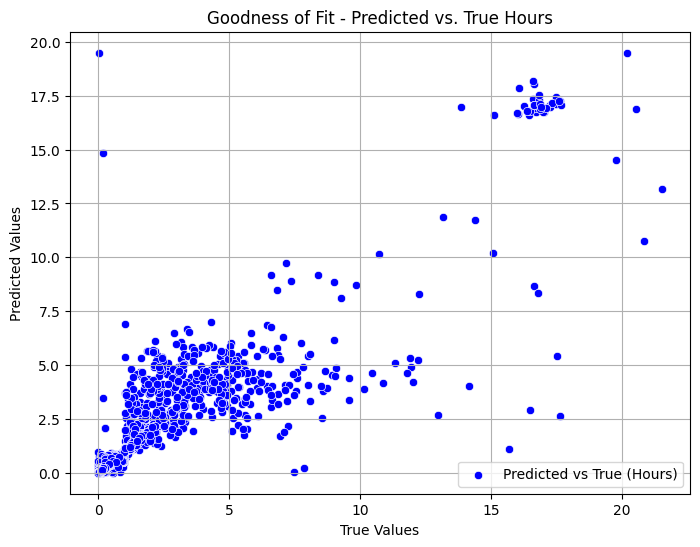

In [101]:
visualize_goodness_of_fit(y_val/3600, y_pred/3600)

* we can see that most of the points cluster closely around a diagonal line, indicating a good fit between the model predictions and the actual values

In [102]:
best_model = KNeighborsRegressor(**{'weights': 'distance', 'n_neighbors': 7})
display_model_performance_results(best_model, df_train_encoded_scaled)

Validation sets Scores summary on all folds:
Average f1 score on 5 fold cross validation: 0.959406553272639
Average mean squared Logarithmic error score on 5 fold cross validation: 0.5278464531677255
Average R squared score on 5 fold cross validation: 0.836154386134462


* better on all metrics than baseline, especially significantly better on msle

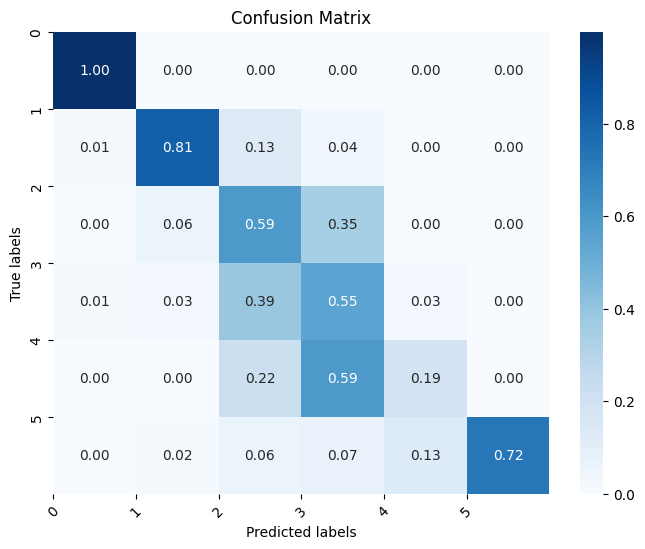

In [103]:
cm = plot_confusion_matrix(y_val, y_pred)

In [104]:
runtime_buckets_value_counts = df_train_encoded_scaled.seconds.apply(lambda x: seconds2bucket(x)).value_counts()
precision, recall, f1_score_ = calc_classification_metrics_per_class(cm)

for i in range(cm.shape[0]):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score_[i]:.4f}, Original Class numb of samples: {runtime_buckets_value_counts.loc[i]}")

Class 0: Precision=0.9746, Recall=0.9992, F1 Score=0.9868, Original Class numb of samples: 32740
Class 1: Precision=0.8870, Recall=0.8149, F1 Score=0.8494, Original Class numb of samples: 2169
Class 2: Precision=0.4264, Recall=0.5905, F1 Score=0.4952, Original Class numb of samples: 1315
Class 3: Precision=0.3419, Recall=0.5500, F1 Score=0.4217, Original Class numb of samples: 863
Class 4: Precision=0.5450, Recall=0.1852, F1 Score=0.2764, Original Class numb of samples: 169
Class 5: Precision=0.9996, Recall=0.7222, F1 Score=0.8386, Original Class numb of samples: 244


* Misrepresented classes performance is harmed, can be improved by oversampling minority classes as discussed in the EDA section, that will be done later on in this notebook.

## Feature selection

In [68]:
k_values = [5, 10, 15, 20, 25, 50, 100]
best_score = -np.inf
best_k = None
best_features_indices = None
n_samples, n_features = df_train_encoded_scaled.shape
X = df_train_encoded_scaled.drop('seconds', axis=1)
y = df_train_encoded_scaled.seconds
model = KNeighborsRegressor(**{'weights': 'distance', 'n_neighbors': 7})

# Perform cross-validation for each k (numb of desired features) value
for k in k_values:
    print(f'calculating score for {k} best features...')
    feature_selector = SelectKBest(score_func=f_regression, k=k)
    # Transform X_train and perform cross-validation
    X_selected = feature_selector.fit_transform(X, y)
    cv_scores = cross_val_score(model, X_selected, y, cv=5, scoring='r2')
    mean_score = np.mean(cv_scores)
    # add a penalty of number of features
    numb_of_features_normalized_penalty = (k * np.log(n_samples)) / n_samples
    # Adjust the mean score with the numb of features penalty
    adjusted_score = mean_score - numb_of_features_normalized_penalty
    if adjusted_score > best_score:
        best_score = adjusted_score
        best_k = k
        best_features_indices = feature_selector.get_support(indices=True)
        print('current best adjusted score:', best_score)

best_features_dict = {'k_best_features': best_features_indices}
best_features_dict

calculating score for 5 best features...
current best adjusted score: 0.6076452031751889
calculating score for 10 best features...
current best adjusted score: 0.7209018807996602
calculating score for 15 best features...
current best adjusted score: 0.7483618331691276
calculating score for 20 best features...
current best adjusted score: 0.7586784024866304
calculating score for 25 best features...
current best adjusted score: 0.7705158443089928
calculating score for 50 best features...
current best adjusted score: 0.7875375753427323
calculating score for 100 best features...


{'k_best_features': array([  0,   1,   3,   4,   8,  13,  28,  31,  51,  54,  56,  59,  60,
         62,  68,  87,  88,  96, 112, 117, 126, 128, 129, 137, 139, 140,
        149, 162, 175, 177, 179, 181, 197, 204, 213, 215, 236, 251, 262,
        263, 279, 288, 304, 317, 323, 324, 332, 336, 355, 356])}

In [69]:
len(best_features_dict['k_best_features']) # 50 features had the best weighted R squared score

50

In [71]:
X.iloc[:, best_features_dict['k_best_features']].columns

Index(['feature_1', 'feature_3', 'feature_5', 'feature_6', 'feature_2_0a95d',
       'feature_2_23908', 'feature_2_564a3', 'feature_2_6531b',
       'feature_2_a6f73', 'feature_2_b3bd8', 'feature_2_bf00f',
       'feature_2_d9df6', 'feature_2_dab03', 'feature_2_dde94',
       'feature_0_04aa6', 'feature_0_3d27a', 'feature_0_3f6e3',
       'feature_0_4b920', 'feature_0_92356', 'feature_0_b8404',
       'feature_0_d4ba7', 'feature_0_d7618', 'feature_0_d84e6',
       'feature_0_f4142', 'feature_0_f7c05', 'feature_0_fd3af',
       'feature_9_Anne Smith', 'feature_9_Brandon James',
       'feature_9_Clive Gardner', 'feature_9_Connor Brown',
       'feature_9_Craig Williamson', 'feature_9_David Hudson',
       'feature_9_Dr Debra Davies', 'feature_9_Dr Josh Butcher',
       'feature_9_Dr Peter Marsh', 'feature_9_Dr Timothy Whittaker',
       'feature_9_Jake Dixon', 'feature_9_Josephine Webb',
       'feature_9_Liam Macdonald-Fox', 'feature_9_Liam Thomas',
       'feature_9_Mohammad Jones-Dav

* as suspected in the category encoding section, feature_4 and feature_10, that are categorical columns with a large number of unique categories, thata look like a hash of previous information are not selected
* as suspected in the EDA section, feature_9 (names of people) was suspected to be important, and we see a lot of categories from it selected.

### let's check if the other metrics weren't significantly lowered

In [108]:
selected_columns = ['seconds']
selected_columns.extend(list(X.iloc[:, best_features_dict['k_best_features']].columns))
subset_df_train_encoded_scaled = df_train_encoded_scaled.loc[:, selected_columns]
selected_columns.remove('seconds')
subset_df_test_encoded_scaled = df_test_encoded_scaled.loc[:, selected_columns]

In [109]:
subset_df_train_encoded_scaled.head(3)

,seconds,feature_1,feature_3,feature_5,feature_6,feature_2_0a95d,feature_2_23908,feature_2_564a3,feature_2_6531b,feature_2_a6f73,...,feature_9_Mohammad Jones-Davies,feature_9_Mr Glenn Lewis,feature_9_Ms Amy Harding,feature_9_Oliver West,feature_9_Rachael Bond,feature_9_Rachael Moore-Pearson,feature_9_Roy Jackson,feature_9_Sara Cooper,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams
0,17482.052,0.917788,0.638889,0.0,0.011029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,64.141,0.234372,0.627778,1.0,0.003676,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.301,0.318668,0.305556,1.0,0.025735,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
subset_df_test_encoded_scaled.head(3)

,feature_1,feature_3,feature_5,feature_6,feature_2_0a95d,feature_2_23908,feature_2_564a3,feature_2_6531b,feature_2_a6f73,feature_2_b3bd8,...,feature_9_Mohammad Jones-Davies,feature_9_Mr Glenn Lewis,feature_9_Ms Amy Harding,feature_9_Oliver West,feature_9_Rachael Bond,feature_9_Rachael Moore-Pearson,feature_9_Roy Jackson,feature_9_Sara Cooper,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams
0,0.198848,0.646296,1.0,0.003676,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.198848,0.040741,1.0,0.003676,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.588124,0.638889,1.0,0.011029,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
best_model = KNeighborsRegressor(**{'weights': 'distance', 'n_neighbors': 7})
X_train, X_val, y_train, y_val = split_into_train_and_validation(subset_df_train_encoded_scaled)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

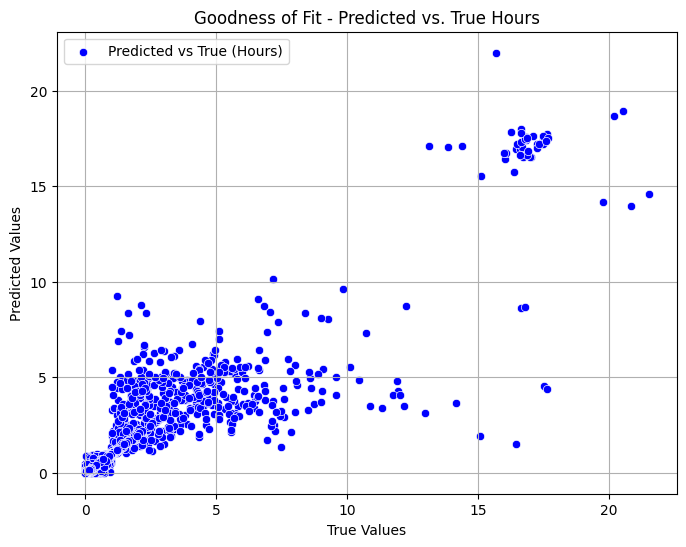

In [112]:
visualize_goodness_of_fit(y_val/3600, y_pred/3600)

* looks very similar to the previous goodness of fit plot

In [113]:
best_model = KNeighborsRegressor(**{'weights': 'distance', 'n_neighbors': 7})
display_model_performance_results(best_model, subset_df_train_encoded_scaled)

Validation sets Scores summary on all folds:
Average f1 score on 5 fold cross validation: 0.9603889048162267
Average mean squared Logarithmic error score on 5 fold cross validation: 0.5964187614254259
Average R squared score on 5 fold cross validation: 0.8043061580264297


* no significant drop in performance across all metrics, but we gain a lighter model of a much lesser dimension

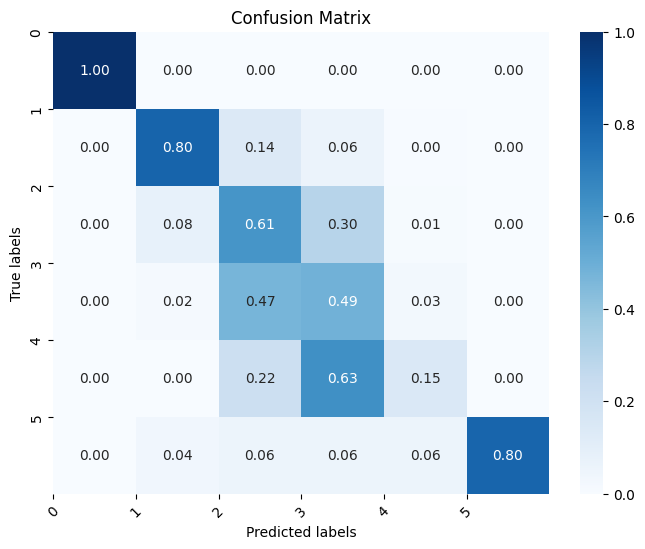

In [114]:
cm = plot_confusion_matrix(y_val, y_pred)

In [115]:
runtime_buckets_value_counts = subset_df_train_encoded_scaled.seconds.apply(lambda x: seconds2bucket(x)).value_counts()
precision, recall, f1_score_ = calc_classification_metrics_per_class(cm)

for i in range(cm.shape[0]):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score_[i]:.4f}, Original Class numb of samples: {runtime_buckets_value_counts.loc[i]}")

Class 0: Precision=1.0000, Recall=1.0000, F1 Score=1.0000, Original Class numb of samples: 32740
Class 1: Precision=0.8530, Recall=0.7991, F1 Score=0.8252, Original Class numb of samples: 2169
Class 2: Precision=0.4091, Recall=0.6121, F1 Score=0.4904, Original Class numb of samples: 1315
Class 3: Precision=0.3189, Recall=0.4875, F1 Score=0.3856, Original Class numb of samples: 863
Class 4: Precision=0.6126, Recall=0.1481, F1 Score=0.2386, Original Class numb of samples: 169
Class 5: Precision=1.0000, Recall=0.7963, F1 Score=0.8866, Original Class numb of samples: 244


again very similar to the full data model results

## Optimization

- convert the problem into a classification problem by clustering the seconds column into buckets
- take the best model parameters, the best selected features, and re train on classification problem while oversampling minority classes to see if it will improve f1 scores on the different classes

In [116]:
## REGRESSION TO CLASSIFICATION CONVERSION
clf_model = KNeighborsClassifier(**{'weights': 'distance', 'n_neighbors': 7})
best_k_train_set = subset_df_train_encoded_scaled.copy()
best_k_test_set = subset_df_test_encoded_scaled.copy()
best_k_train_set.seconds = best_k_train_set.seconds.apply(lambda s: seconds2bucket(s)) # convert seconds to runtime buckets
best_k_train_set.rename(columns={'seconds': 'runtime_buckets'},inplace=True)
best_k_train_set.head(3)

,runtime_buckets,feature_1,feature_3,feature_5,feature_6,feature_2_0a95d,feature_2_23908,feature_2_564a3,feature_2_6531b,feature_2_a6f73,...,feature_9_Mohammad Jones-Davies,feature_9_Mr Glenn Lewis,feature_9_Ms Amy Harding,feature_9_Oliver West,feature_9_Rachael Bond,feature_9_Rachael Moore-Pearson,feature_9_Roy Jackson,feature_9_Sara Cooper,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams
0,3,0.917788,0.638889,0.0,0.011029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.234372,0.627778,1.0,0.003676,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.318668,0.305556,1.0,0.025735,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [117]:
best_k_train_set.runtime_buckets.value_counts() # class imbalance shown clearly

0    32740
1     2169
2     1315
3      863
5      244
4      169
Name: runtime_buckets, dtype: int64

## train and evaluate model before balancing minority classes

In [120]:
display_model_performance_results(clf_model, best_k_train_set, k=5, problem_type='classification')

Validation sets Scores summary on all folds:
Average f1 score on 5 fold cross validation: 0.9604500724311276


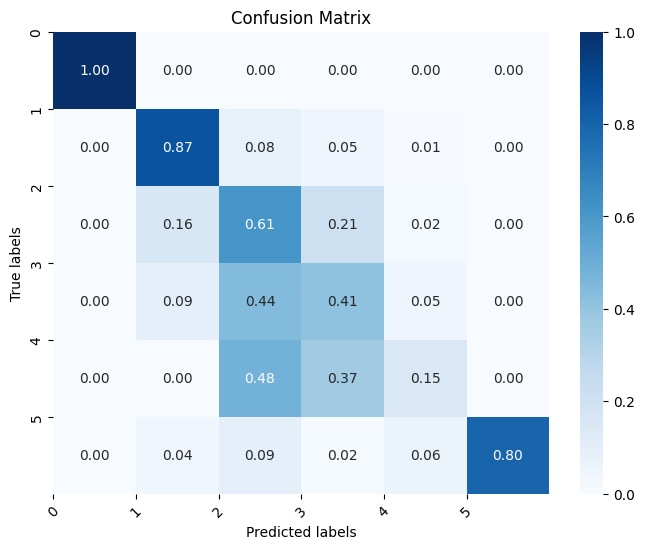

In [121]:
clf_model = KNeighborsClassifier(**{'weights': 'distance', 'n_neighbors': 7})
X_train, X_val, y_train, y_val = split_into_train_and_validation(best_k_train_set, target_column='runtime_buckets')
clf_model.fit(X_train, y_train)
y_pred = clf_model.predict(X_val)
cm = plot_confusion_matrix(y_val, y_pred, problem_type='classification')

In [122]:
runtime_buckets_value_counts = dict(best_k_train_set.runtime_buckets.value_counts())

In [123]:
precision, recall, f1_score_ = calc_classification_metrics_per_class(cm)

for i in range(cm.shape[0]):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score_[i]:.4f}, Original Class numb of samples: {runtime_buckets_value_counts[i]}")

Class 0: Precision=1.0000, Recall=1.0000, F1 Score=1.0000, Original Class numb of samples: 32740
Class 1: Precision=0.7491, Recall=0.8668, F1 Score=0.8037, Original Class numb of samples: 2169
Class 2: Precision=0.3577, Recall=0.6121, F1 Score=0.4515, Original Class numb of samples: 1315
Class 3: Precision=0.3900, Recall=0.4125, F1 Score=0.4009, Original Class numb of samples: 863
Class 4: Precision=0.5334, Recall=0.1481, F1 Score=0.2319, Original Class numb of samples: 169
Class 5: Precision=1.0000, Recall=0.7963, F1 Score=0.8866, Original Class numb of samples: 244


* not much of a difference from the regression model, slightly better in some classes, slightly worse in other classes...

In [124]:
runtime_buckets_value_counts

{0: 32740, 1: 2169, 2: 1315, 3: 863, 5: 244, 4: 169}

## try again after oversampling (but not balancing) minority classes using the SMOTE algorithm
* oversample minority classes while keeping the order the same (class 0 > class 1 > class 2 > class 3 >  class 5 > class 4)

In [125]:
# define the strategy -> the number of desired clases in minority classes
strategy_dict = {}
for key, val in runtime_buckets_value_counts.items():
    if key == 0:
        strategy_dict[key] = val
    else:
        strategy_dict[key] = val * 10 # lower the ratio between class 0 and the rest of the classes by 1 order of magnitude

"original numb of samples in classes:", dict(runtime_buckets_value_counts), "desired numb of samples in classes:", strategy_dict

('original numb of samples in classes:',
 {0: 32740, 1: 2169, 2: 1315, 3: 863, 5: 244, 4: 169},
 'desired numb of samples in classes:',
 {0: 32740, 1: 21690, 2: 13150, 3: 8630, 5: 2440, 4: 1690})

In [126]:
best_k_train_set_copy = best_k_train_set.copy()

In [127]:
def perform_synthetic_minority_oversampling(df, target_column, custom_strategy):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    smote = SMOTE(sampling_strategy=custom_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    # Create a new array to indicate whether each sample is synthetic (1) or not (0)
    synthetic_flag = np.hstack((np.zeros(len(X)), np.ones(len(X_resampled) - len(X))))
    # Concatenate the synthetic flag with the original target column and features
    df_resampled = pd.concat([
        pd.Series(y_resampled, name=target_column),
        pd.Series(synthetic_flag, name='is_synthetic'),
        pd.DataFrame(X_resampled, columns=X.columns),
    ], axis=1)
    return df_resampled


df_oversampled = perform_synthetic_minority_oversampling(best_k_train_set_copy, 'runtime_buckets', strategy_dict)

In [131]:
df_oversampled.head(3)

,runtime_buckets,is_synthetic,feature_1,feature_3,feature_5,feature_6,feature_2_0a95d,feature_2_23908,feature_2_564a3,feature_2_6531b,...,feature_9_Mohammad Jones-Davies,feature_9_Mr Glenn Lewis,feature_9_Ms Amy Harding,feature_9_Oliver West,feature_9_Rachael Bond,feature_9_Rachael Moore-Pearson,feature_9_Roy Jackson,feature_9_Sara Cooper,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams
0,3,0.0,0.917788,0.638889,0.0,0.011029,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.234372,0.627778,1.0,0.003676,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.318668,0.305556,1.0,0.025735,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
df_oversampled.runtime_buckets.value_counts()

0    32740
1    21690
2    13150
3     8630
5     2440
4     1690
Name: runtime_buckets, dtype: int64

In [129]:
df_oversampled[~(df_oversampled.is_synthetic==1)].shape[0] == best_k_train_set.shape[0] # original samples kept

True

In [130]:
f"numb of rows before oversampling: {best_k_train_set.shape[0]}, numb of rows after oversampling: {df_oversampled.shape[0]}"

'numb of rows before oversampling: 37500, numb of rows after oversampling: 80340'

### Evaluate the model again after oversampling

In [132]:
## keep only original not synthetic samples in validation set.
val_indices = list(df_oversampled[df_oversampled.is_synthetic==0].sample(int(0.2 * len(df_oversampled))).index)
train_indices = list(set(df_oversampled.index) - set(val_indices))
if len(set(train_indices) & set(val_indices)) > 0:
    raise Exception('FOUND DATA LEAKAGE! THERE ARE SOME INTERSECTED TRAIN AND VALIDATION SAMPLES.....')
df_oversampled.drop('is_synthetic', axis=1, inplace=True)
X_train = df_oversampled.iloc[train_indices, :].drop('runtime_buckets', axis=1)
y_train = df_oversampled.loc[train_indices, 'runtime_buckets']
X_val = df_oversampled.iloc[val_indices, :].drop('runtime_buckets', axis=1)
y_val = df_oversampled.loc[val_indices, 'runtime_buckets']

* The reason we excluded synthetic samples from the validation set is because in all the pipeline the performance of the various models is measured by calculating f1_score (among other scores), and f1_score calculation is a weighted result of the different f1 scores on all classes based on their appearance, so in order for us to know how to compare this result to other results, we will make sure that the validation set class distribution is similar to pervious validation sets class distribition, while oversamplng the minority classes in the train set and training on a more balanced set.

In [133]:
y_val.value_counts() # similar imbalance to prev validation sets

0    14041
1      912
2      593
3      360
5       96
4       66
Name: runtime_buckets, dtype: int64

In [134]:
clf_model = KNeighborsClassifier(**{'weights': 'distance', 'n_neighbors': 7})
clf_model.fit(X_train, y_train)
y_pred = clf_model.predict(X_val)

<Axes: >

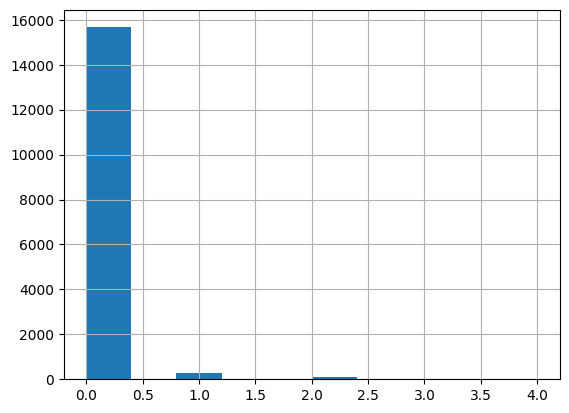

In [135]:
error = abs(y_val - y_pred)
error.hist()

* if the error is not 0 then most likely it's 1 according to the histogram, which excellent because we have ordinal relationship between the classes

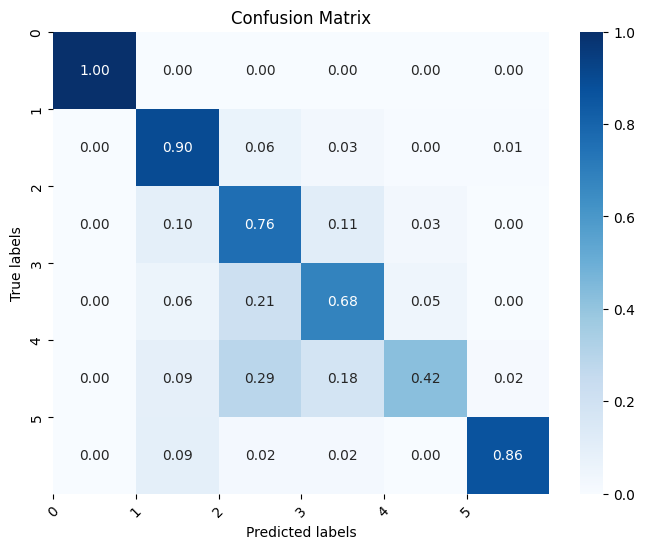

In [137]:
cm = plot_confusion_matrix(y_val, y_pred, problem_type='classification')

In [138]:
runtime_buckets_value_counts = dict(df_oversampled.runtime_buckets.value_counts())
precision, recall, f1_score_ = calc_classification_metrics_per_class(cm)

for i in range(cm.shape[0]):
    print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1 Score={f1_score_[i]:.4f}, Original Class numb of samples: {runtime_buckets_value_counts[i]}")

Class 0: Precision=1.0000, Recall=1.0000, F1 Score=1.0000, Original Class numb of samples: 32740
Class 1: Precision=0.7256, Recall=0.8969, F1 Score=0.8022, Original Class numb of samples: 21690
Class 2: Precision=0.5647, Recall=0.7605, F1 Score=0.6482, Original Class numb of samples: 13150
Class 3: Precision=0.6634, Recall=0.6806, F1 Score=0.6719, Original Class numb of samples: 8630
Class 4: Precision=0.8381, Recall=0.4242, F1 Score=0.5633, Original Class numb of samples: 1690
Class 5: Precision=0.9767, Recall=0.8646, F1 Score=0.9172, Original Class numb of samples: 2440


* significant improvement from the regression model f1 scores for all classes.
* class 0 (majority class) performance is not hurt

In [139]:
calc_f1_score(y_val, y_pred, problem_type='classification')

0.9750138404323764

# Train on all of the data before providing results on test set

In [140]:
df_oversampled

,runtime_buckets,feature_1,feature_3,feature_5,feature_6,feature_2_0a95d,feature_2_23908,feature_2_564a3,feature_2_6531b,feature_2_a6f73,...,feature_9_Mohammad Jones-Davies,feature_9_Mr Glenn Lewis,feature_9_Ms Amy Harding,feature_9_Oliver West,feature_9_Rachael Bond,feature_9_Rachael Moore-Pearson,feature_9_Roy Jackson,feature_9_Sara Cooper,feature_9_Tom Evans-Dixon,feature_9_Trevor Adams
0,3,0.917788,0.638889,0.0,0.011029,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.234372,0.627778,1.0,0.003676,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.318668,0.305556,1.0,0.025735,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.560646,0.570370,0.0,0.003676,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.722082,0.309259,1.0,0.003676,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80335,5,0.867301,0.709259,0.0,0.003676,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80336,5,0.519594,0.709259,0.0,0.003676,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80337,5,0.621584,0.709259,0.0,0.003676,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80338,5,0.549375,0.709259,0.0,0.003676,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
clf_model = KNeighborsClassifier(**{'weights': 'distance', 'n_neighbors': 7})
clf_model.fit(df_oversampled.drop('runtime_buckets', axis=1), df_oversampled.runtime_buckets)
overfitted_y_pred = clf_model.predict(df_oversampled.drop('runtime_buckets', axis=1))

In [143]:
abs(overfitted_y_pred - df_oversampled.runtime_buckets).value_counts() # almost no errors, what we expected

0    80329
1        9
2        2
Name: runtime_buckets, dtype: int64

In [147]:
# My predictions:
bucket_pred_test = clf_model.predict(best_k_test_set)
# bucket_pred_test = [seconds2bucket(pred) for pred in y_pred_test]

In [148]:
# Save predictions
pd.Series(bucket_pred_test).to_csv(PATH_TO_FILES+"/y_preds.csv", index=False)